# COGS 118A Final Project Fall 2024

## Dataset 1: [Dataset for Assessing Mathematics Learning in Higher Education](https://archive.ics.uci.edu/dataset/1031/dataset+for+assessing+mathematics+learning+in+higher+education)


In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

### EDA and Preprocessing


In [2]:
dataset = pd.read_csv('data/math-dataset.csv', delimiter=';')

dataset.head()

,Student ID,Student Country,Question ID,Type of Answer,Question Level,Topic,Subtopic,Keywords
0,647,Ireland,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
1,41,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
2,340,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
3,641,Italy,77,0,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."
4,669,Portugal,77,1,Basic,Statistics,Statistics,"Stem and Leaf diagram,Relative frequency,Sampl..."


In [3]:
dataset.shape

(9546, 8)

In [4]:
dataset['Question ID'].value_counts()

Question ID
452     103
459     103
317     101
455      99
435      95
       ... 
872       1
905       1
906       1
909       1
1549      1
Name: count, Length: 833, dtype: int64

In [5]:
# Check for missing values
dataset.isnull().sum()

Student ID         0
Student Country    0
Question ID        0
Type of Answer     0
Question Level     0
Topic              0
Subtopic           0
Keywords           0
dtype: int64

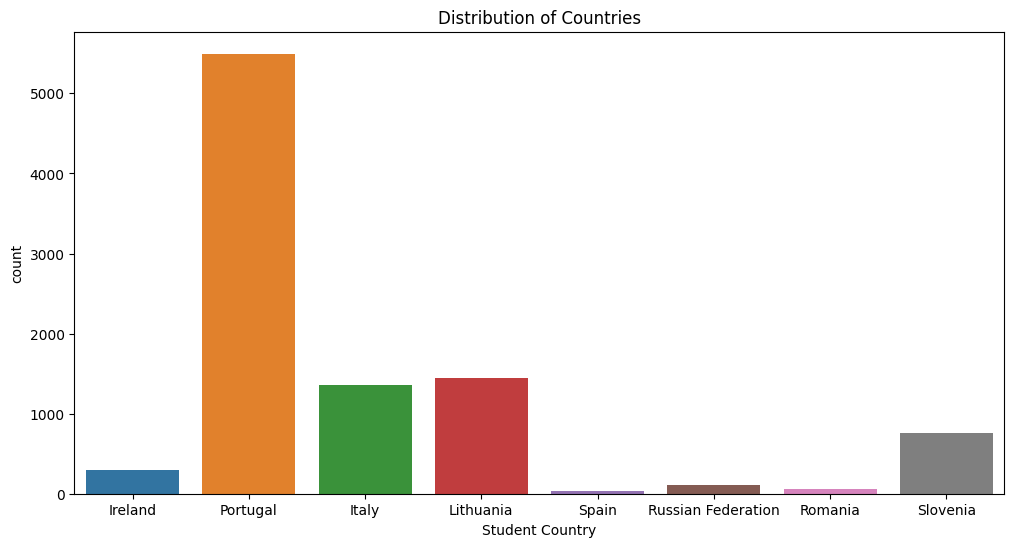

In [6]:
# plot distribution of countries
plt.figure(figsize=(12, 6))
sns.countplot(x='Student Country', data=dataset, hue='Student Country')
plt.title('Distribution of Countries')
plt.show()

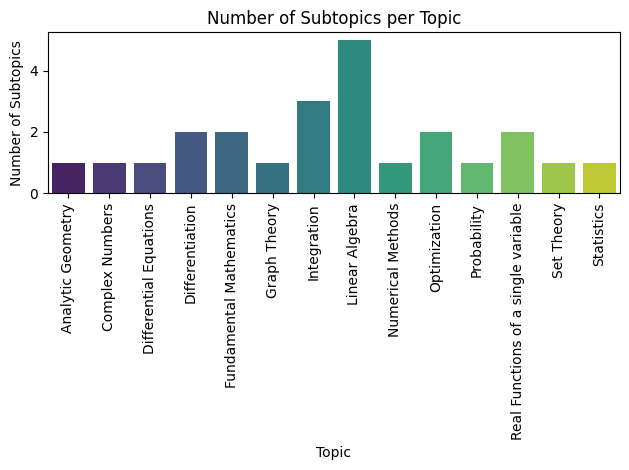

In [7]:
# plot the number of different subtopics for a given topic
subtopic_counts = dataset.groupby("Topic")["Subtopic"].nunique().reset_index()
subtopic_counts.columns = ["Topic", "SubtopicCount"]

sns.barplot(data=subtopic_counts, x="Topic",
            y="SubtopicCount", hue='Topic', palette="viridis")
plt.title("Number of Subtopics per Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Subtopics")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

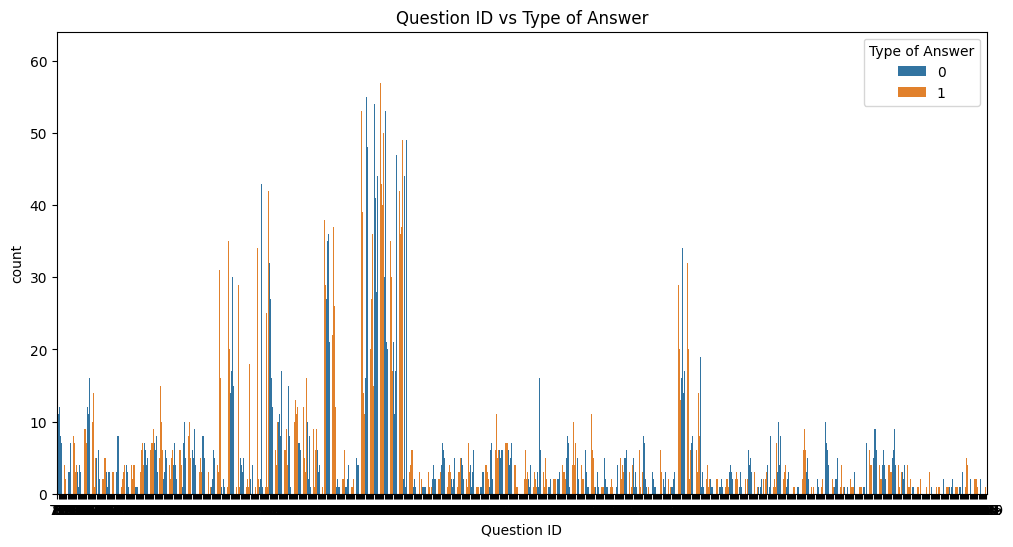

In [8]:
# plot question ID vs type of answer
plt.figure(figsize=(12, 6))
sns.countplot(x='Question ID', data=dataset, hue='Type of Answer')
plt.title('Question ID vs Type of Answer')
plt.show()

While the keywords column and question id have relevant information, it will be hard to use for our purposes so will drop this column for the purposes of this project.


In [9]:
dataset.drop(['Student ID', 'Keywords', 'Question ID'], inplace=True, axis=1)

dataset.head()

,Student Country,Type of Answer,Question Level,Topic,Subtopic
0,Ireland,0,Basic,Statistics,Statistics
1,Portugal,1,Basic,Statistics,Statistics
2,Portugal,1,Basic,Statistics,Statistics
3,Italy,0,Basic,Statistics,Statistics
4,Portugal,1,Basic,Statistics,Statistics


## Logistic Regression


In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [11]:
# Determine all unique categories beforehand
country_categories = dataset['Student Country'].unique()
level_categories = dataset['Question Level'].unique()
topic_categories = dataset['Topic'].unique()
subtopic_categories = dataset['Subtopic'].unique()

# Update OneHotEncoder with explicit categories
preprocessor = ColumnTransformer(
    transformers=[
        ('country_enc', OneHotEncoder(handle_unknown='ignore', drop='if_binary',
                                      categories=[country_categories]), ['Student Country']),
        ('level_enc', OneHotEncoder(handle_unknown='ignore', drop='if_binary',
                                    categories=[level_categories]), ['Question Level']),
        ('topic_enc', OneHotEncoder(handle_unknown='ignore', drop='if_binary',
                                    categories=[topic_categories]), ['Topic']),
        ('subtopic_enc', OneHotEncoder(handle_unknown='ignore', drop='if_binary',
                                       categories=[subtopic_categories]), ['Subtopic'])
    ],
    remainder='drop'
)


def comprehensive_model_evaluation(X, y, classifier, param_grid, split_ratios=[0.2, 0.5, 0.8]):
    """
    Comprehensive model evaluation across multiple splits and configurations
    """
    all_results = []

    for test_size in tqdm(split_ratios, desc="Split Ratios"):
        for seed in tqdm(range(3), desc="Random Seeds", leave=False):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42 + seed)

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', classifier)
            ])

            grid_search = GridSearchCV(
                pipeline,
                param_grid,
                cv=5,
                scoring='accuracy',
                n_jobs=-1
            )
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_
            train_pred = best_model.predict(X_train)
            test_pred = best_model.predict(X_test)

            result = {
                'Test Size': f"{int((1-test_size)*100)}-{int(test_size*100)}",
                'Random Seed': seed,
                'Best Params': str(grid_search.best_params_),
                'Best CV Score': grid_search.best_score_,
                'Train Accuracy': accuracy_score(y_train, train_pred),
                'Test Accuracy': accuracy_score(y_test, test_pred),
                'Classifier': type(classifier).__name__
            }

            report = classification_report(y_test, test_pred, output_dict=True)
            result.update({
                'Macro Precision': report['macro avg']['precision'],
                'Macro Recall': report['macro avg']['recall'],
                'Macro F1-Score': report['macro avg']['f1-score']
            })

            all_results.append(result)

    results_df = pd.DataFrame(all_results)
    print("Evaluation Summary:")
    print(results_df.groupby(['Test Size', 'Classifier'])[
          ['Train Accuracy', 'Test Accuracy', 'Best CV Score']].agg(['mean', 'std']))

    return results_df

In [12]:
X = dataset.drop(columns=['Type of Answer'])
y = dataset['Type of Answer']

In [13]:
y.value_counts()

Type of Answer
0    5076
1    4470
Name: count, dtype: int64

## Logistic Regression


In [14]:
lr_param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
}

# Comprehensive evaluation
lr_results = comprehensive_model_evaluation(
    X, y,
    LogisticRegression(),
    lr_param_grid
)

lr_results

Split Ratios: 100%|██████████| 3/3 [00:06<00:00,  2.11s/it]

Evaluation Summary:
                             Train Accuracy           Test Accuracy            \
                                       mean       std          mean       std   
Test Size Classifier                                                            
19-80     LogisticRegression       0.594552  0.015932      0.571865  0.012411   
50-50     LogisticRegression       0.592499  0.002956      0.576507  0.002240   
80-20     LogisticRegression       0.587087  0.002734      0.575742  0.010489   

                             Best CV Score            
                                      mean       std  
Test Size Classifier                                  
19-80     LogisticRegression      0.582668  0.008615  
50-50     LogisticRegression      0.582026  0.000420  
80-20     LogisticRegression      0.581063  0.003295  


,Test Size,Random Seed,Best Params,Best CV Score,Train Accuracy,Test Accuracy,Classifier,Macro Precision,Macro Recall,Macro F1-Score
0,80-20,0,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.584861,0.588921,0.563874,LogisticRegression,0.565356,0.553439,0.537391
1,80-20,1,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.578967,0.588397,0.579581,LogisticRegression,0.585512,0.568823,0.552360
2,80-20,2,"{'classifier__C': 10, 'classifier__penalty': '...",0.579360,0.583944,0.583770,LogisticRegression,0.591184,0.572194,0.554828
3,50-50,0,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.581606,0.592080,0.575110,LogisticRegression,0.576547,0.563036,0.548973
4,50-50,1,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.582447,0.589776,0.575320,LogisticRegression,0.571981,0.564240,0.557415
5,50-50,2,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.582025,0.595642,0.579091,LogisticRegression,0.580366,0.571719,0.563645
6,19-80,0,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.579345,0.602410,0.577190,LogisticRegression,0.574939,0.565671,0.557371
7,19-80,1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.592450,0.605029,0.580725,LogisticRegression,0.580087,0.568468,0.558294
8,19-80,2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.576210,0.576218,0.557680,LogisticRegression,0.618171,0.534844,0.446968


## K-Nearest Neighbors


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif

In [16]:
knn_param_grid = {
    # K from 1 to 104 with step 4
    'classifier__n_neighbors': np.arange(1, 105, 4),
    # 'uniform' or 'distance' weights
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],  # Distance metrics
}

# Assuming 'comprehensive_model_evaluation' is a function for evaluation
knn_results = comprehensive_model_evaluation(
    X, y,
    KNeighborsClassifier(),
    knn_param_grid
)

knn_results

Split Ratios: 100%|██████████| 3/3 [01:38<00:00, 33.00s/it]

Evaluation Summary:
                               Train Accuracy           Test Accuracy  \
                                         mean       std          mean   
Test Size Classifier                                                    
19-80     KNeighborsClassifier       0.624236  0.004001      0.578892   
50-50     KNeighborsClassifier       0.611495  0.001901      0.596201   
80-20     KNeighborsClassifier       0.609918  0.005121      0.592496   

                                         Best CV Score            
                                     std          mean       std  
Test Size Classifier                                              
19-80     KNeighborsClassifier  0.004683      0.590708  0.008015  
50-50     KNeighborsClassifier  0.005047      0.589149  0.002380  
80-20     KNeighborsClassifier  0.008719      0.596734  0.005223  


,Test Size,Random Seed,Best Params,Best CV Score,Train Accuracy,Test Accuracy,Classifier,Macro Precision,Macro Recall,Macro F1-Score
0,80-20,0,"{'classifier__metric': 'euclidean', 'classifie...",0.601492,0.614196,0.582723,KNeighborsClassifier,0.581977,0.576363,0.572095
1,80-20,1,"{'classifier__metric': 'manhattan', 'classifie...",0.597565,0.611315,0.595288,KNeighborsClassifier,0.601033,0.585911,0.574827
2,80-20,2,"{'classifier__metric': 'manhattan', 'classifie...",0.591145,0.604243,0.599476,KNeighborsClassifier,0.608452,0.588696,0.574928
3,50-50,0,"{'classifier__metric': 'euclidean', 'classifie...",0.590824,0.613241,0.590404,KNeighborsClassifier,0.589706,0.582054,0.577054
4,50-50,1,"{'classifier__metric': 'euclidean', 'classifie...",0.590199,0.611775,0.598575,KNeighborsClassifier,0.600420,0.585813,0.576702
5,50-50,2,"{'classifier__metric': 'manhattan', 'classifie...",0.586424,0.609470,0.599623,KNeighborsClassifier,0.604713,0.591759,0.582962
6,19-80,0,"{'classifier__metric': 'manhattan', 'classifie...",0.595597,0.623363,0.583213,KNeighborsClassifier,0.582295,0.571234,0.562230
7,19-80,1,"{'classifier__metric': 'manhattan', 'classifie...",0.595069,0.628601,0.573916,KNeighborsClassifier,0.570200,0.567569,0.566069
8,19-80,2,"{'classifier__metric': 'euclidean', 'classifie...",0.581458,0.620744,0.579547,KNeighborsClassifier,0.584169,0.567540,0.551305


## Decision Trees


In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
dt_param_grid = {
    # Maximum depth of the tree
    'classifier__max_depth': [None, 5, 10, 20, 30],
    # Minimum number of samples required to split a node
    'classifier__min_samples_split': [2, 5, 10],
    # Minimum number of samples required to be at a leaf node
    'classifier__min_samples_leaf': [1, 2, 4],
    # The function to measure the quality of a split
    'classifier__criterion': ['gini', 'entropy'],
    # Strategy used to split at each node
    'classifier__splitter': ['best', 'random'],
    # The number of features to consider for the best split
    'classifier__max_features': [None, 'sqrt', 'log2']
}

# Model evaluation using comprehensive_model_evaluation
dt_results = comprehensive_model_evaluation(
    X, y,
    DecisionTreeClassifier(),
    dt_param_grid
)

dt_results

Split Ratios: 100%|██████████| 3/3 [01:08<00:00, 22.95s/it]

Evaluation Summary:
                                 Train Accuracy           Test Accuracy  \
                                           mean       std          mean   
Test Size Classifier                                                      
19-80     DecisionTreeClassifier       0.613934  0.008233      0.575619   
50-50     DecisionTreeClassifier       0.609610  0.000484      0.593058   
80-20     DecisionTreeClassifier       0.610878  0.004256      0.593717   

                                           Best CV Score            
                                       std          mean       std  
Test Size Classifier                                                
19-80     DecisionTreeClassifier  0.008869      0.596468  0.006670  
50-50     DecisionTreeClassifier  0.002965      0.591173  0.002150  
80-20     DecisionTreeClassifier  0.012379      0.600531  0.003723  


,Test Size,Random Seed,Best Params,Best CV Score,Train Accuracy,Test Accuracy,Classifier,Macro Precision,Macro Recall,Macro F1-Score
0,80-20,0,"{'classifier__criterion': 'gini', 'classifier_...",0.603586,0.615113,0.580628,DecisionTreeClassifier,0.580423,0.573488,0.567644
1,80-20,1,"{'classifier__criterion': 'entropy', 'classifi...",0.601623,0.610922,0.595288,DecisionTreeClassifier,0.601303,0.585807,0.574414
2,80-20,2,"{'classifier__criterion': 'entropy', 'classifi...",0.596385,0.606600,0.605236,DecisionTreeClassifier,0.609498,0.596598,0.588966
3,50-50,0,"{'classifier__criterion': 'gini', 'classifier_...",0.593547,0.609889,0.591452,DecisionTreeClassifier,0.592840,0.581434,0.573279
4,50-50,1,"{'classifier__criterion': 'entropy', 'classifi...",0.590617,0.609051,0.596480,DecisionTreeClassifier,0.597106,0.584339,0.576327
5,50-50,2,"{'classifier__criterion': 'gini', 'classifier_...",0.589355,0.609889,0.591242,DecisionTreeClassifier,0.595795,0.583075,0.573098
6,19-80,0,"{'classifier__criterion': 'entropy', 'classifi...",0.600831,0.617601,0.582690,DecisionTreeClassifier,0.580047,0.572934,0.567832
7,19-80,1,"{'classifier__criterion': 'entropy', 'classifi...",0.599783,0.604505,0.565667,DecisionTreeClassifier,0.562175,0.561022,0.560551
8,19-80,2,"{'classifier__criterion': 'entropy', 'classifi...",0.588791,0.619696,0.578499,DecisionTreeClassifier,0.583234,0.566317,0.549424


## Bagging Decisoin Tree


In [19]:
from sklearn.ensemble import BaggingClassifier

In [20]:
bagging_param_grid = {
    # Number of base estimators (trees)
    'classifier__n_estimators': [10, 50, 100, 200],
    # Proportion of samples to train each base estimator
    'classifier__max_samples': [0.5, 0.7, 1.0],
    # Proportion of features to train each base estimator
    'classifier__max_features': [0.5, 0.7, 1.0],
    # Whether to use bootstrap sampling
    'classifier__bootstrap': [True, False],
    # Base estimator (Decision Tree)
    'classifier__estimator': [DecisionTreeClassifier(random_state=42)],
    'classifier__random_state': [42]  # For reproducibility
}

# Model evaluation using comprehensive_model_evaluation
bagging_results = comprehensive_model_evaluation(
    X, y,
    BaggingClassifier(),
    bagging_param_grid
)

Split Ratios: 100%|██████████| 3/3 [02:59<00:00, 59.70s/it]

Evaluation Summary:
                            Train Accuracy           Test Accuracy            \
                                      mean       std          mean       std   
Test Size Classifier                                                           
19-80     BaggingClassifier       0.624411  0.009268      0.580682  0.006247   
50-50     BaggingClassifier       0.610867  0.002428      0.591173  0.003315   
80-20     BaggingClassifier       0.611228  0.003929      0.593717  0.013358   

                            Best CV Score            
                                     mean       std  
Test Size Classifier                                 
19-80     BaggingClassifier      0.593854  0.007331  
50-50     BaggingClassifier      0.593687  0.001192  
80-20     BaggingClassifier      0.600444  0.004587  


In [21]:
bagging_results

,Test Size,Random Seed,Best Params,Best CV Score,Train Accuracy,Test Accuracy,Classifier,Macro Precision,Macro Recall,Macro F1-Score
0,80-20,0,"{'classifier__bootstrap': False, 'classifier__...",0.604503,0.615113,0.580628,BaggingClassifier,0.580318,0.573592,0.567965
1,80-20,1,"{'classifier__bootstrap': False, 'classifier__...",0.601362,0.611315,0.593194,BaggingClassifier,0.598436,0.583863,0.572833
2,80-20,2,"{'classifier__bootstrap': True, 'classifier__e...",0.595468,0.607255,0.607330,BaggingClassifier,0.611279,0.598967,0.592020
3,50-50,0,"{'classifier__bootstrap': True, 'classifier__e...",0.595014,0.613660,0.588309,BaggingClassifier,0.590299,0.577561,0.567623
4,50-50,1,"{'classifier__bootstrap': False, 'classifier__...",0.593340,0.609679,0.590404,BaggingClassifier,0.591469,0.577102,0.566537
5,50-50,2,"{'classifier__bootstrap': True, 'classifier__e...",0.592707,0.609260,0.594804,BaggingClassifier,0.601293,0.586138,0.574730
6,19-80,0,"{'classifier__bootstrap': False, 'classifier__...",0.599784,0.625982,0.585963,BaggingClassifier,0.584419,0.575135,0.568390
7,19-80,1,"{'classifier__bootstrap': False, 'classifier__...",0.596119,0.632792,0.582297,BaggingClassifier,0.579029,0.574872,0.572484
8,19-80,2,"{'classifier__bootstrap': True, 'classifier__e...",0.585658,0.614458,0.573786,BaggingClassifier,0.576492,0.562020,0.546291


## Random Forest


In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
rf_param_grid = {
    'classifier__n_estimators': [1024],  # Number of trees set to 1024
    # Various options for max_features
    'classifier__max_features': [1, 2, 4, 6, 8, 12, 16, 20],
    'classifier__random_state': [42]  # For reproducibility
}

# Model evaluation using comprehensive_model_evaluation
rf_results = comprehensive_model_evaluation(
    X, y,
    RandomForestClassifier(),
    rf_param_grid
)

rf_results

Split Ratios: 100%|██████████| 3/3 [03:47<00:00, 75.83s/it] 

Evaluation Summary:
                                 Train Accuracy           Test Accuracy  \
                                           mean       std          mean   
Test Size Classifier                                                      
19-80     RandomForestClassifier       0.626506  0.006041      0.582209   
50-50     RandomForestClassifier       0.612263  0.002446      0.593896   
80-20     RandomForestClassifier       0.611228  0.003929      0.593892   

                                           Best CV Score            
                                       std          mean       std  
Test Size Classifier                                                
19-80     RandomForestClassifier  0.003536      0.586344  0.008644  
50-50     RandomForestClassifier  0.002766      0.588240  0.005151  
80-20     RandomForestClassifier  0.013352      0.598044  0.003597  


,Test Size,Random Seed,Best Params,Best CV Score,Train Accuracy,Test Accuracy,Classifier,Macro Precision,Macro Recall,Macro F1-Score
0,80-20,0,"{'classifier__max_features': 1, 'classifier__n...",0.600313,0.615113,0.580628,RandomForestClassifier,0.580318,0.573592,0.567965
1,80-20,1,"{'classifier__max_features': 1, 'classifier__n...",0.599922,0.611315,0.593717,RandomForestClassifier,0.598988,0.584414,0.573485
2,80-20,2,"{'classifier__max_features': 2, 'classifier__n...",0.593897,0.607255,0.607330,RandomForestClassifier,0.611050,0.599075,0.592362
3,50-50,0,"{'classifier__max_features': 4, 'classifier__n...",0.594177,0.614917,0.591452,RandomForestClassifier,0.591926,0.582117,0.575365
4,50-50,1,"{'classifier__max_features': 1, 'classifier__n...",0.585588,0.611775,0.596899,RandomForestClassifier,0.597031,0.585218,0.578042
5,50-50,2,"{'classifier__max_features': 4, 'classifier__n...",0.584955,0.610098,0.593338,RandomForestClassifier,0.597007,0.585690,0.577289
6,19-80,0,"{'classifier__max_features': 4, 'classifier__n...",0.586169,0.625982,0.585701,RandomForestClassifier,0.583920,0.575133,0.568822
7,19-80,1,"{'classifier__max_features': 6, 'classifier__n...",0.595074,0.632792,0.582297,RandomForestClassifier,0.579015,0.574958,0.572657
8,19-80,2,"{'classifier__max_features': 20, 'classifier__...",0.577789,0.620744,0.578630,RandomForestClassifier,0.580977,0.567689,0.554797


In [24]:
combined_results = pd.concat([
    lr_results, 
    knn_results, 
    dt_results, 
    bagging_results, 
    rf_results
])

# Aggregate and compare key metrics
comparison_summary = combined_results.groupby('Classifier')[
    ['Test Accuracy', 'Macro F1-Score', 'Best CV Score']
].agg(['mean', 'std'])

In [25]:
comparison_summary

Test Accuracy           Macro F1-Score            \
                                mean       std           mean       std   
Classifier                                                                
BaggingClassifier           0.588524  0.009640       0.569875  0.011768   
DecisionTreeClassifier      0.587465  0.011798       0.570171  0.010967   
KNeighborsClassifier        0.589196  0.009652       0.570908  0.009569   
LogisticRegression          0.574704  0.008480       0.541916  0.036368   
RandomForestClassifier      0.589999  0.009151       0.573421  0.009983   

                       Best CV Score            
                                mean       std  
Classifier                                      
BaggingClassifier           0.595995  0.005494  
DecisionTreeClassifier      0.596058  0.005680  
KNeighborsClassifier        0.592197  0.006028  
LogisticRegression          0.581919  0.004669  
RandomForestClassifier      0.590876  0.007624

In [28]:
import openpyxl
comparison_summary.to_excel('model_comparison_summary.xlsx')

In [29]:

combined_results

,Test Size,Random Seed,Best Params,Best CV Score,Train Accuracy,Test Accuracy,Classifier,Macro Precision,Macro Recall,Macro F1-Score
0,80-20,0,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.584861,0.588921,0.563874,LogisticRegression,0.565356,0.553439,0.537391
1,80-20,1,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.578967,0.588397,0.579581,LogisticRegression,0.585512,0.568823,0.552360
2,80-20,2,"{'classifier__C': 10, 'classifier__penalty': '...",0.579360,0.583944,0.583770,LogisticRegression,0.591184,0.572194,0.554828
3,50-50,0,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.581606,0.592080,0.575110,LogisticRegression,0.576547,0.563036,0.548973
4,50-50,1,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.582447,0.589776,0.575320,LogisticRegression,0.571981,0.564240,0.557415
5,50-50,2,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.582025,0.595642,0.579091,LogisticRegression,0.580366,0.571719,0.563645
6,19-80,0,"{'classifier__C': 1, 'classifier__penalty': 'l...",0.579345,0.602410,0.577190,LogisticRegression,0.574939,0.565671,0.557371
7,19-80,1,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.592450,0.605029,0.580725,LogisticRegression,0.580087,0.568468,0.558294
8,19-80,2,"{'classifier__C': 0.1, 'classifier__penalty': ...",0.576210,0.576218,0.557680,LogisticRegression,0.618171,0.534844,0.446968
0,80-20,0,"{'classifier__metric': 'euclidean', 'classifie...",0.601492,0.614196,0.582723,KNeighborsClassifier,0.581977,0.576363,0.572095


In [34]:
avg_performance = (
    combined_results.groupby(['Test Size', 'Classifier'])[
        ['Best CV Score', 'Train Accuracy', 'Test Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score']
    ]
    .mean()
    .reset_index()
)

# Sorting results for better readability
avg_performance = avg_performance.sort_values(by=['Classifier']).reset_index(drop=True)

avg_performance

,Test Size,Classifier,Best CV Score,Train Accuracy,Test Accuracy,Macro Precision,Macro Recall,Macro F1-Score
0,19-80,BaggingClassifier,0.593854,0.624411,0.580682,0.579980,0.570676,0.562388
1,50-50,BaggingClassifier,0.593687,0.610867,0.591173,0.594353,0.580267,0.569630
2,80-20,BaggingClassifier,0.600444,0.611228,0.593717,0.596678,0.585474,0.577606
3,19-80,DecisionTreeClassifier,0.596468,0.613934,0.575619,0.575152,0.566758,0.559269
4,50-50,DecisionTreeClassifier,0.591173,0.609610,0.593058,0.595247,0.582949,0.574235
5,80-20,DecisionTreeClassifier,0.600531,0.610878,0.593717,0.597074,0.585298,0.577008
6,19-80,KNeighborsClassifier,0.590708,0.624236,0.578892,0.578888,0.568781,0.559868
7,50-50,KNeighborsClassifier,0.589149,0.611495,0.596201,0.598280,0.586542,0.578906
8,80-20,KNeighborsClassifier,0.596734,0.609918,0.592496,0.597154,0.583656,0.573950
9,19-80,LogisticRegression,0.582668,0.594552,0.571865,0.591066,0.556327,0.520878


In [35]:
avg_performance.to_excel('average_performance.xlsx')

In [51]:
best_params = combined_results.groupby(['Classifier', 'Best Params'])['Test Size'].apply(list).reset_index()


In [52]:
best_params

,Classifier,Best Params,Test Size
0,BaggingClassifier,"{'classifier__bootstrap': False, 'classifier__...",[50-50]
1,BaggingClassifier,"{'classifier__bootstrap': False, 'classifier__...",[19-80]
2,BaggingClassifier,"{'classifier__bootstrap': False, 'classifier__...","[80-20, 19-80]"
3,BaggingClassifier,"{'classifier__bootstrap': False, 'classifier__...",[80-20]
4,BaggingClassifier,"{'classifier__bootstrap': True, 'classifier__e...",[19-80]
5,BaggingClassifier,"{'classifier__bootstrap': True, 'classifier__e...",[50-50]
6,BaggingClassifier,"{'classifier__bootstrap': True, 'classifier__e...",[50-50]
7,BaggingClassifier,"{'classifier__bootstrap': True, 'classifier__e...",[80-20]
8,DecisionTreeClassifier,"{'classifier__criterion': 'entropy', 'classifi...",[19-80]
9,DecisionTreeClassifier,"{'classifier__criterion': 'entropy', 'classifi...",[80-20]
